In [10]:
from scipy.sparse.linalg import splu, factorized
from scipy.linalg import lu_factor, lu_solve
import numpy as np
np.set_printoptions(precision=4) # Print few decimal places
np.set_printoptions(suppress=True) # Suppress scientific notation
import cvxpy as cp
import pandas as pd
from numpy.linalg import cholesky as llt
import matplotlib.pyplot as plt
import scipy.stats as stats
import time

In [11]:
def generate_randn_data(m,n):
    w = np.random.randn(n)
    x = np.maximum(w, 0)
    lambd = np.maximum(-w, 0)
    A = np.random.randn(m,n)
    nu = np.random.randn(m)
    b = A @ x
    
    # TODO: Find expression for c s.t. (x,nu,lambda) is optimal
    c = - A.T @ nu + lambd
    return A, b, c, x, lambd, nu

In [12]:
# NOTE
# Test case and the formulation for the splitting
n = 10
m = 10
A_, b_, c_, x_, lambd_, nu_ = generate_randn_data(m, n)
u = np.random.uniform(np.max(x_), 5*np.max(x_), n) 
l = -u

x_cvxpy = cp.Variable(x_.shape)
objective = cp.Minimize(c_.T @ x_cvxpy)
constraints = [A_ @ x_cvxpy == b_, x_cvxpy >= l, x_cvxpy <= u]
problem = cp.Problem(objective, constraints)
problem.solve()
print(problem.status)
print("cvxpy value =", c_.T @ x_cvxpy.value)
print("actual value =", c_.T @ x_)


x_cvxpy_u = cp.Variable(int(0.5*n))
x_cvxpy_l = cp.Variable(n-int(0.5*n))
objective = cp.Minimize(c_[:int(0.5*n)].T@x_cvxpy_u + c_[int(0.5*n):].T@x_cvxpy_l)
constraints = [A_[:,:int(0.5*n)]@x_cvxpy_u + A_[:,int(0.5*n):]@x_cvxpy_l == b_,
               x_cvxpy_u >= l[:int(0.5*n)], x_cvxpy_l >= l[int(0.5*n):],
               x_cvxpy_u <= u[:int(0.5*n)], x_cvxpy_l <= u[int(0.5*n):]]
problem = cp.Problem(objective, constraints)
problem.solve()
print(problem.status)
print("cvxpy value =", c_[:int(0.5*n)].T@x_cvxpy_u.value + c_[int(0.5*n):].T@x_cvxpy_l.value)
print("actual value =", c_.T @ x_)


optimal
cvxpy value = 3.869686708161278
actual value = 3.8696867081612805
optimal
cvxpy value = 3.869686708161278
actual value = 3.8696867081612805


In [13]:
# NOTE
# I implemented a rudementary version for simplicity and to first make sure that this worked

def ADMM(c1, c2, U, V, q, u, l, xu, xv, y, nu):
    var1 = cp.Variable(xu.shape[0])
    constraint1 = [var1 <= u[:xu.shape[0]], l[:xu.shape[0]] <= var1]
    prob_1 = cp.Problem(cp.Minimize(c1 @ var1 + (nu/2) * cp.sum_squares((U @ var1 + V @ xv - q) - (1/nu) * y)), constraint1)
    prob_1.solve()
    
    xu_next = var1.value
    
    var_2 = cp.Variable(xv.shape[0])
    constraint2 = [var_2 <= u[xv.shape[0]:], l[xv.shape[0]:] <= var_2]
    prob_2 = cp.Problem(cp.Minimize(c2 @ xv + (nu/2) * cp.sum_squares((U @ xu_next + V @ var_2 - q) - (1/nu) * y)), constraint2)
    prob_2.solve()
    
    xv_next = var_2.value
    
    y_next = y - nu * (U @ xu_next + V @ xv_next - q)
    z_hat_next = [xu_next, xv_next, y - nu * (U @ xu_next + V @ xv - q)]
    z_next = [xu_next, xv_next, y_next]
    
    return z_hat_next, z_next

def KKT_error(nu, A, b, K, c, lam, lam_plus, lam_minus, q, l, u, x, y):
    # positive = [max(x,0) for x in (h - G @ x)]
    # matrix = np.vstack([A@x - b, positive])
    
    norm1 = np.linalg.norm(A@x - b, 2) ** 2
    
    norm2 = np.linalg.norm(c - K.T @ y - lam, 2) ** 2
    
    KKT = np.sqrt(nu**2 * norm1 + (1/(nu**2)) * norm2 + (q.T@y + l.T@lam_plus - u.T@lam_minus - c.T@x) ** 2)
    
    return KKT

def lam_comp(A, y, xu, xv, u, l):
    lam_pos = np.ones(xu.shape[0] + xv.shape[0])
    lam_neg = np.ones(xu.shape[0] + xv.shape[0])
    
    for i in range(xu.shape[0]):
        if not abs(xu[i] - l[i]) <= 1e-5:
            lam_pos[i] = 0
        if not abs(xu[i] - u[i]) <= 1e-5:
            lam_neg[i] = 0

    for i in range(xu.shape[0], lam_pos.shape[0]):
        if not abs(xv[i-xu.shape[0]] - l[i]) <= 1e-5:
            lam_pos[i] = 0
        if not abs(xv[i-xu.shape[0]] - u[i]) <= 1e-5:
            lam_neg[i] = 0
            
    for i in range(A.T.shape[0]):
        if lam_pos[i] != 0:
            lam_pos[i] = -(A.T @ y)[i]
        elif lam_neg[i] != 0:
            lam_neg[i] = (A.T @ y)[i] 

    lam = np.vstack([lam_pos, lam_neg])
    
    return lam

In [23]:
# NOTE
# ADMM + Restarts

np.random.seed(142)

n = 100
m = 5 * n
# m = n
A, b, c, x_, lambd, nu = generate_randn_data(m, n)
u = np.random.uniform(np.max(x_), 5*np.max(x_), n) 
l = -u

c1 = c[:int(0.5*n)]
c2 = c[int(0.5*n):]
U = A[:,:int(0.5*n)]
V = A[:,int(0.5*n):]
q = b
xu = np.zeros(int(0.5*n))
xv = np.zeros(n - int(0.5*n))
y = np.zeros(A.shape[0])
# NOTE Not sure if nu is the right value, just choose an argibrary one
nu = 0.3

z = np.zeros(500, dtype=object)
z_bar = 0

K = np.hstack([U, V])
A = np.hstack([U, V])
x = np.hstack([xu, xv])
c = np.hstack([c1, c2])

value_ADMM_restarts = np.zeros(500)

lam = lam_comp(A, y, xu, xv, u, l)
lam_plus = lam[0]
lam_minus = lam[1]

x_cvxpy_u = cp.Variable(int(0.5*n))
x_cvxpy_l = cp.Variable(n-int(0.5*n))
objective = cp.Minimize(c1.T@x_cvxpy_u + c2.T@x_cvxpy_l)
constraints = [U@x_cvxpy_u + V@x_cvxpy_l == b,
               x_cvxpy_u >= l[:int(0.5*n)], x_cvxpy_l >= l[int(0.5*n):],
               x_cvxpy_u <= u[:int(0.5*n)], x_cvxpy_l <= u[int(0.5*n):]]
problem = cp.Problem(objective, constraints)
problem.solve()
print("Did cvxpy converge =", problem.status)
print("cvxpy value =", c1.T@x_cvxpy_u.value + c2.T@x_cvxpy_l.value)
print("actual value =", c.T @ x_)


KKT_prev = np.zeros(20, dtype=object)
# KKT = np.zeros((100,20), dtype=object)


KKT = KKT_error(nu, A, q, K, c, lam, lam_plus, lam_minus, q, l, u, x, y)
KKT_prev[0] = KKT_prev[1] = -np.inf
KKT_n = -np.inf

for f in range(1,2):
    count = 0
    xu = np.zeros(int(0.5*n))
    xv = np.zeros(n - int(0.5*n))
    y = np.zeros(A.shape[0])
    for i in range(100):
        z[i] = z_bar
        xu_bar = 0
        xv_bar = 0
        y_bar = 0
        t = 0
        # print("i", i)
        
        while not ((KKT <= 0.8 * KKT_n and KKT > KKT_prev[0]) or (KKT <= 0.2 * KKT_n) or (t >= max(0.36 * count,1))):
        # for g in range(f):
            z_hat, z_admm = ADMM(c1, c2, U, V, q, u, l, xu, xv, y, nu)
            xu = z_admm[0]
            xv = z_admm[1]
            y = z_admm[2]
            # print("t", t)
            value_ADMM_restarts[count] = abs(c1.T @ xu + c2.T @ xv - problem.value)
            diff = abs(c1.T @ xu + c2.T @ xv - problem.value)
            
            xu_bar = (t/(1+t)) * xu_bar + (1/(1+t)) * z_hat[0]
            xv_bar = (t/(1+t)) * xv_bar + (1/(1+t)) * z_hat[1]
            y_bar = (t/(1+t)) * y_bar + (1/(1+t)) * z_hat[2]
            
            K = np.hstack([U, V])
            A = np.hstack([U, V])
            x = np.hstack([xu, xv])
            c = np.hstack([c1, c2])
            
            lam = lam_comp(A, y, xu, xv, u, l)
            lam_plus = lam[0]
            lam_minus = lam[1]
            lam_KKT = - lam_plus + lam_minus
            KKT = KKT_error(nu, A, q, K, c, lam_KKT, lam_plus, lam_minus, q, l, u, x, y)
            KKT_prev[0] = KKT_prev[1]
            KKT_prev[1] = KKT
            t += 1
            count += 1
            # if (value_ADMM_restarts[count] <= 1e-13):
            if (diff <= 1e-13):
                # print("stoped iterations at index =", i)
                break
        # if value_ADMM_restarts[count] <= 1e-13:
        if diff <= 1e-13:
            print("stoped iterations at index =", i)
            print("count =", count)
            print("f =", f)
            break
        if count >= 100:
            print("For f =", f, "we go over 100 iterations")
            break
        
        KKT_n = KKT
        xu = xu_bar
        xv = xv_bar
        y = y_bar
        z_bar = [xu, xv, y]

print("count =", count)
print("ADMM with restarts value =", c1.T @ xu + c2.T @ xv)

Did cvxpy converge = optimal
cvxpy value = -305.46254458881356
actual value = -305.4625445888135
For f = 1 we go over 100 iterations
count = 113
ADMM with restarts value = -305.4625445888131


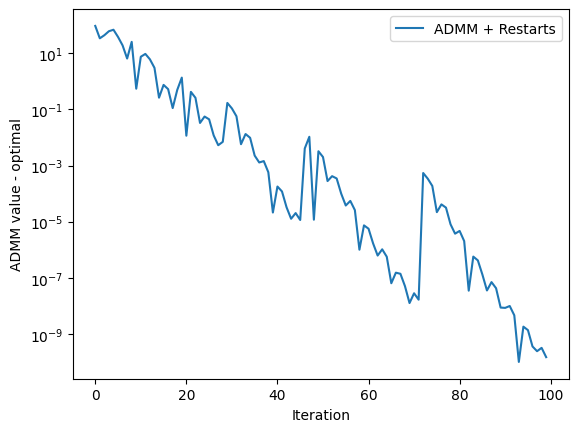

In [15]:
plt.plot(value_ADMM_restarts[:100], label='ADMM + Restarts')
plt.yscale('log')
plt.ylabel('ADMM value - optimal')
plt.xlabel('Iteration')
plt.legend()

In [16]:
# NOTE
# ADMM


np.random.seed(142)

n = 100
m = 5 * n
A, b, c, x, lambd, nu = generate_randn_data(m, n)
u = np.random.uniform(np.max(x), 5*np.max(x), n) 
l = -u

c1 = c[:int(0.5*n)]
c2 = c[int(0.5*n):]
U = A[:,:int(0.5*n)]
V = A[:,int(0.5*n):]
q = b
xu = np.zeros(int(0.5*n))
xv = np.zeros(n - int(0.5*n))
y = np.zeros(A.shape[0])
# NOTE Not sure if nu is the right value, just choose an argibrary one
nu = 0.3

x_cvxpy_u = cp.Variable(int(0.5*n))
x_cvxpy_l = cp.Variable(n-int(0.5*n))
objective = cp.Minimize(c1.T@x_cvxpy_u + c2.T@x_cvxpy_l)
constraints = [U@x_cvxpy_u + V@x_cvxpy_l == b,
               x_cvxpy_u >= l[:int(0.5*n)], x_cvxpy_l >= l[int(0.5*n):],
               x_cvxpy_u <= u[:int(0.5*n)], x_cvxpy_l <= u[int(0.5*n):]]
problem = cp.Problem(objective, constraints)
problem.solve()
print("Did cvxpy converge =", problem.status)
print("cvxpy value =", c1.T@x_cvxpy_u.value + c2.T@x_cvxpy_l.value)
print("actual value =", c.T @ x)


value_ADMM = np.zeros(500)

for i in range(500):
    z_hat, z = ADMM(c1, c2, U, V, q, u, l, xu, xv, y, nu)
    xu = z[0]
    xv = z[1]
    y = z[2]
    value_ADMM[i] = abs(c1.T @ xu + c2.T @ xv - problem.value)
    if value_ADMM[i] <= 1e-13:
        print("stoped iterations at index =", i)
        break
print("ADMM value =", c1.T @ xu + c2.T @ xv)

Did cvxpy converge = optimal
cvxpy value = -305.46254458881356
actual value = -305.4625445888135
stoped iterations at index = 62
ADMM value = -305.46254458881356


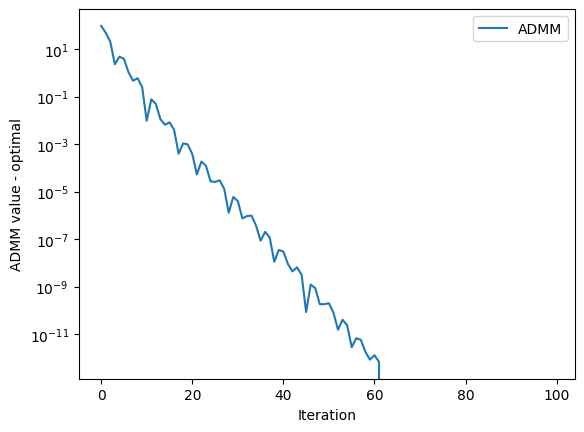

In [17]:

plt.plot(value_ADMM[:100], label='ADMM')
plt.yscale('log')
plt.ylabel('ADMM value - optimal')
plt.xlabel('Iteration')
plt.legend()
# plt.ylim(10**-10, 1)